In [1]:
import xarray as xr
import einops
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.utils import shuffle

In [2]:
year = '2020'
month = '05'

In [3]:
def _rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(
        a, shape=shape, strides=strides, writeable=False
    )

def balance_classes(a, boo):
    lsn=len(a.sample_number)
    ind = np.arange(lsn)
    ind_true = shuffle(ind[boo])
    ind_false = ind[~boo]
    ind_true = ind_true[:np.sum(~boo)]
    print(1-(2*len(ind_false)/lsn))
    return a.isel(sample_number=np.concatenate([ind_true,ind_false]))

last_hour = range(-1,-60,-1)


In [4]:
ds_rad = xr.open_dataset('/pd/data/CML/data/reference/radklim_yw_1min/2018_2020_radklim_yw_1_min.nc', engine='netcdf4')
ds_cml1 = xr.open_dataset('/pd/data/CML/data/processed/proc2021.001/proc_hess_amt/proc_cnn_gapstandard_'+year+'_'+month+'.nc', engine='netcdf4')
ds_rad = ds_rad.reindex(time=ds_cml1.time.values,method='nearest',tolerance='10s')
ds_cml1['radar_rainfall'] = ds_rad.rainfall_amount
ds_cml1 = ds_cml1.load()


In [5]:
for cml_batch in tqdm(np.arange(len(ds_cml1.cml_id)//50)):
    cml_batch = np.arange(50)+(cml_batch*50)
    ds_cml = ds_cml1.isel(cml_id=cml_batch).copy()

    ds_cml['r_median_tl'] = ds_cml.txrx.rolling(time=60*72, min_periods=60*3).median()
    ds_cml['tl_norm'] = ds_cml['txrx']-ds_cml['r_median_tl']
    # ds_cml = ds_cml.sel(time=slice('2020-05-20','2020-05-30'))
    tl = einops.rearrange(ds_cml.tl_norm.values, 'c i t -> t i c')
    rr = ds_cml.radar_rainfall.values

    l = []
    r = []
    for i in tqdm(range(tl.shape[1])):
        tll = []
        for j in range(tl.shape[2]):
            tll.append(_rolling_window(tl[:,i,j], 180))
        r.append(_rolling_window(rr[:,i], 180))
        l.append(tll)
    l = einops.rearrange(np.array(l), 'i c b t -> (b i) t c')
    r = einops.rearrange(np.array(r), 'i b t -> (b i) t')
    ds = xr.Dataset()
    ds['tl'] = ('sample_number','timestep','channel_id',), l
    ds['radar'] = ('sample_number','timestep',), r
    ds['tl_valid'] = ds.tl.isnull().sum(dim='timestep').sum(dim='channel_id')==0
    ds = ds.sel(sample_number=ds.sample_number[ds.tl_valid])
    ds['wet_radar'] = ds.radar.isel(timestep=last_hour).sum('timestep')>0.1

    ds = balance_classes(ds, ~ds.wet_radar.values)
    ds['tl'] = ds.tl.transpose('sample_number', 'channel_id', 'timestep')
    ds.to_netcdf('/bg/fast/aihydromet/cml_wet_dry_radklim/train_data_'+year+'_'+month+'_'+str(cml_batch[0])+'-'+str(cml_batch[-1])+'.nc')

100%|██████████| 50/50 [00:00<00:00, 56118.60it/s]


0.8824725030723743


100%|██████████| 50/50 [00:00<00:00, 51539.74it/s]


0.8731590831785497


100%|██████████| 50/50 [00:00<00:00, 45669.69it/s]


0.9076650058016518


100%|██████████| 50/50 [00:00<00:00, 47716.77it/s]


0.9222267288582437


100%|██████████| 50/50 [00:00<00:00, 25571.91it/s]


0.9253605054228229


100%|██████████| 50/50 [00:00<00:00, 36333.19it/s]


0.9276136773759421


100%|██████████| 50/50 [00:00<00:00, 48657.82it/s]


0.929687177539851


100%|██████████| 50/50 [00:00<00:00, 23956.50it/s]


0.9166535875365527


100%|██████████| 50/50 [00:00<00:00, 25820.64it/s]


0.9085790057690626


100%|██████████| 50/50 [00:00<00:00, 48567.67it/s]


0.8952992111627344


100%|██████████| 50/50 [00:00<00:00, 52285.02it/s]


0.8981540849069181


100%|██████████| 50/50 [00:00<00:00, 27568.71it/s]


0.8994276255093262


100%|██████████| 50/50 [00:00<00:00, 24789.03it/s]


0.9006904775662545


100%|██████████| 50/50 [00:00<00:00, 31333.51it/s]


0.8872497508219493


100%|██████████| 50/50 [00:00<00:00, 27189.84it/s]


0.8952238971624193


100%|██████████| 50/50 [00:00<00:00, 50267.31it/s]


0.8980769758880249


100%|██████████| 50/50 [00:00<00:00, 27186.31it/s]


0.8993995376230477


100%|██████████| 50/50 [00:00<00:00, 46274.32it/s]


0.8975051234793938


100%|██████████| 50/50 [00:00<00:00, 25830.18it/s]


0.8864965843653347


100%|██████████| 50/50 [00:00<00:00, 25817.46it/s]


0.8995611180575325


100%|██████████| 50/50 [00:00<00:00, 24448.03it/s]


0.8967404982630846


100%|██████████| 50/50 [00:00<00:00, 29789.09it/s]


0.9405920406404148


100%|██████████| 50/50 [00:00<00:00, 25306.53it/s]


0.8978328592451071


100%|██████████| 50/50 [00:00<00:00, 24462.29it/s]


0.9096492233049507


100%|██████████| 50/50 [00:00<00:00, 24385.49it/s]t]


0.9124992904438229


100%|██████████| 50/50 [00:00<00:00, 31736.56it/s]t]


0.9063270515611499


100%|██████████| 50/50 [00:00<00:00, 28248.28it/s]t]


0.9183345755031532


100%|██████████| 50/50 [00:00<00:00, 25519.01it/s]t]


0.9046722696159504


100%|██████████| 50/50 [00:00<00:00, 28343.72it/s]t]


0.9025084617697627


100%|██████████| 50/50 [00:00<00:00, 24742.24it/s]t]


0.9087971077180025


100%|██████████| 50/50 [00:00<00:00, 29997.88it/s]t]


0.9171906424748897


100%|██████████| 50/50 [00:00<00:00, 50147.11it/s]t]


0.9272622163602353


100%|██████████| 50/50 [00:00<00:00, 27049.56it/s]t]


0.9122000969230232


100%|██████████| 50/50 [00:00<00:00, 35269.96it/s]t]


0.9142523202035719


100%|██████████| 50/50 [00:00<00:00, 29742.62it/s]t]


0.9243456196581197


100%|██████████| 50/50 [00:00<00:00, 27496.42it/s]t]


0.9194033245595522


100%|██████████| 50/50 [00:00<00:00, 54429.07it/s]t]


0.9113345089824747


100%|██████████| 50/50 [00:00<00:00, 29537.35it/s]t]


0.9087072311885758


100%|██████████| 50/50 [00:00<00:00, 27292.45it/s]t]


0.9113011610303955


100%|██████████| 50/50 [00:00<00:00, 52665.80it/s]t]


0.9224179816729542


100%|██████████| 50/50 [00:00<00:00, 29396.58it/s]t]


0.9180325260094628


100%|██████████| 50/50 [00:00<00:00, 32727.09it/s]t]


0.9166988009835866


100%|██████████| 50/50 [00:00<00:00, 35508.84it/s]t]


0.9150250176959381


100%|██████████| 50/50 [00:00<00:00, 57096.43it/s]t]


0.8568644141161965


100%|██████████| 50/50 [00:00<00:00, 28567.66it/s]t]


0.8450486353791623


100%|██████████| 50/50 [00:00<00:00, 25565.67it/s]t]


0.8530661785577949


100%|██████████| 50/50 [00:00<00:00, 49872.82it/s]t]


0.8496276569841887


100%|██████████| 50/50 [00:00<00:00, 30170.51it/s]t]


0.8504879903214855


100%|██████████| 50/50 [00:00<00:00, 28451.39it/s]t]


0.8531756004392137


100%|██████████| 50/50 [00:00<00:00, 30062.39it/s]t]


0.7950041173232618


100%|██████████| 50/50 [00:00<00:00, 30517.35it/s]t]


0.7961139907064271


100%|██████████| 50/50 [00:00<00:00, 30122.84it/s]t]


0.7854848978779356


100%|██████████| 50/50 [00:00<00:00, 29587.36it/s]t]


0.802848245093979


 68%|██████▊   | 53/78 [2:16:56<1:04:35, 155.03s/it]


KeyboardInterrupt: 

In [9]:
ds = xr.open_dataset('/bg/fast/aihydromet/cml_wet_dry_radklim/example_test_data.nc')

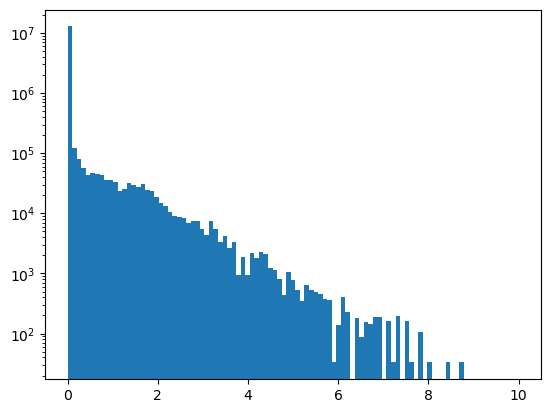

In [19]:
plt.hist(np.ravel(ds.radar.values)*60, bins=np.linspace(0,10,100))
plt.yscale('log')

In [27]:
ds['wet_radar'] = ((ds.radar*60)>0.1).isel(timestep=-5)


In [22]:
np.sum(ds.wet_radar)/len(np.ravel(ds.wet_radar.values))

<xarray.DataArray 'wet_radar' ()> Size: 8B
array(0.06721498)

In [23]:
from sklearn.utils import shuffle

In [33]:
def balance_classes(a, boo):
    lsn=len(a.sample_number)
    ind = np.arange(lsn)
    ind_true = shuffle(ind[boo])
    ind_false = ind[~boo]
    ind_true = ind_true[:np.sum(~boo)]
    print(1-(2*len(ind_false)/lsn))
    return a.isel(sample_number=np.concatenate([ind_true,ind_false]))

In [34]:
a = balance_classes(ds, ~ds.wet_radar.values)

0.8728228678782501


In [35]:
a

<xarray.Dataset> Size: 42MB
Dimensions:    (sample_number: 9748, timestep: 180, channel_id: 2)
Dimensions without coordinates: sample_number, timestep, channel_id
Data variables:
    tl         (sample_number, timestep, channel_id) float64 28MB -2.0 ... -1.3
    radar      (sample_number, timestep) float64 14MB 0.0 0.0 ... 0.0009235
    tl_valid   (sample_number) bool 10kB ...
    wet_radar  (sample_number) bool 10kB False False False ... True True True